In [61]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/cf/24/271e77c22724f370c24c705f394b8035b4d27e4c2c6339f3f45ab9b8258e/tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
  Obtaining dependency information for tensorflow-intel==2.18.0 from https://files.pythonhosted.org/packages/76/ad/fa6c508a15ff79cb5409294c293388e0999b7d480f84b65e4287277434fe/tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7

ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'D:\\individu-feature-from-voice\\.venv\\Lib\\site-packages\\~umpy.libs\\libscipy_openblas64_-c16e4918366c6bc1f1cd71e28ca36fc0.dll'
Check the permissions.


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd

In [3]:
data_path = r"D:\datasets\cv-corpus-19.0-2024-09-13-fr\cv-corpus-19.0-2024-09-13\fr"

# Hyperparameters
age_loss_weight = 0.5
gender_loss_weight = 0.5
learning_rate = 0.001

In [47]:
label_data = pd.read_csv(f"{data_path}/validated_filtered.csv", sep=",")

In [48]:
label_data.isna().sum()

path        0
sentence    0
age         0
gender      0
dtype: int64

In [49]:
label_data.head()

,path,sentence,age,gender
0,common_voice_fr_17323684.mp3,Puis me regardant d'un air peu sympathique,fifties,female_feminine
1,common_voice_fr_19737278.mp3,Ronit est une jeune femme indépendante qui tra...,fifties,female_feminine
2,common_voice_fr_22078126.mp3,cinq,fifties,female_feminine
3,common_voice_fr_22078130.mp3,non,fifties,female_feminine
4,common_voice_fr_22765327.mp3,La technique des statues de terre cuite témoig...,fifties,female_feminine


In [62]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


def load_audio_data(data_path, label_data):
    for path in label_data['path']:
        pass


def preprocess_audio_data(audio_data):
    return audio_data


def show_distrib(df):
    """
    Plot the distribution of age by gender
    :param df:
    :return:
    """
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data=df, x='age', hue='gender', multiple='stack', stat='count')

    # Annotate the bars with their counts
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.title('Distribution of Age by Gender')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()


def preprocess_label_data(label_data, keep_age=False):
    gender_dict = {
        'male_masculine': 0,
        'female_feminine': 1
    }
    label_data = label_data.copy()
    if keep_age:
        serie_age = label_data['age'].copy()
    label_data = pd.get_dummies(label_data, columns=['age'])
    label_data['gender'] = label_data['gender'].map(gender_dict)
    return pd.concat([label_data, serie_age], axis=1) if keep_age else label_data


def split_label_data(label_data, train_ratio=0.8, random_state=0):
    train_data, test_data = train_test_split(label_data, train_size=train_ratio, random_state=random_state,
                                             stratify=label_data['gender'])
    return train_data, test_data

In [63]:
Y_train, Y_test = split_label_data(preprocess_label_data(label_data))

In [64]:
Y_train.head()

,path,sentence,gender,age_fifties,age_fourties,age_seventies,age_sixties,age_teens,age_thirties,age_twenties
46039,common_voice_fr_27544434.mp3,que par un petit nombre de voyageurs curieux.,1,False,False,True,False,False,False,False
38235,common_voice_fr_19590376.mp3,Il est le martyr de Val Cavargna.,1,False,True,False,False,False,False,False
45246,common_voice_fr_19988688.mp3,L'admission à l'École de droit de l'Université...,1,False,False,True,False,False,False,False
1722,common_voice_fr_19645777.mp3,"Mais Marc, victime d'un infarctus, ne vient pa...",1,True,False,False,False,False,False,False
50374,common_voice_fr_19949393.mp3,Il comptait neuf communes réparties en deux ce...,1,False,False,False,True,False,False,False


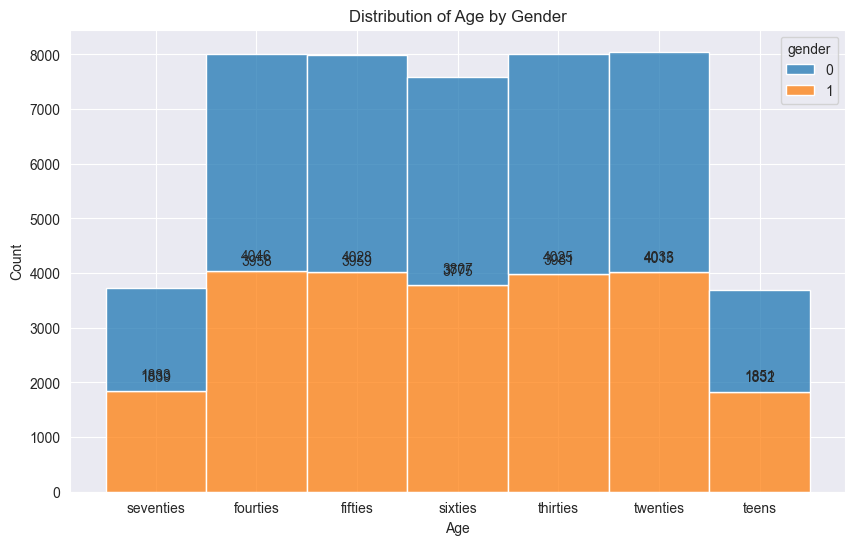

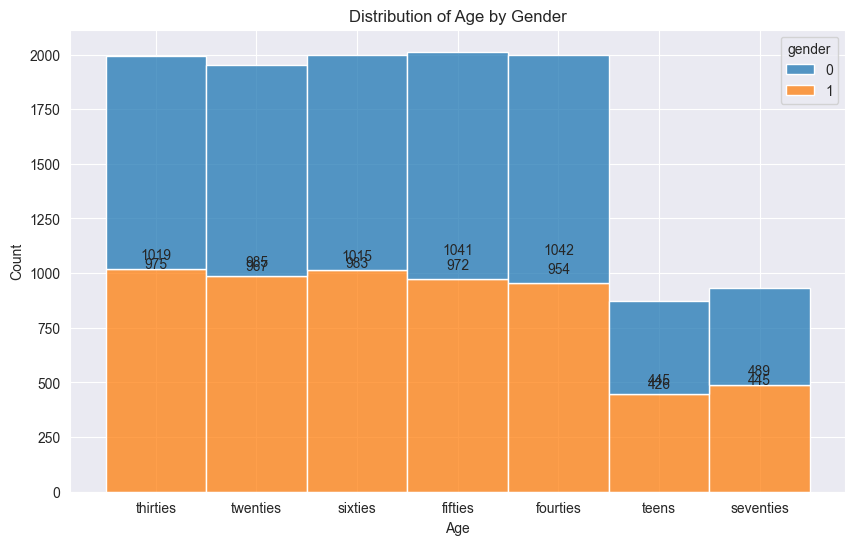

In [60]:
# Only run if keep age is True
show_distrib(Y_train)
show_distrib(Y_test)

In [ ]:
import tensorflow as tf

def custom_loss(y_true, y_pred):
    """
    Custom loss function for the model. Must predict the age and gender of the speaker.
    prediction: [X X X X X X X] + [X]
                    age           gender
    Use the following loss functions:
    - age: mean squared error
    - gender: binary crossentropy
    :param y_true:
    :param y_pred:
    :return:
    """
    age_true = y_true[:, :-1]
    age_pred = y_pred[:, :-1]
    gender_true = y_true[:, -1]
    gender_pred = y_pred[:, -1]
    age_loss = tf.keras.losses.MeanSquaredError()(age_true, age_pred)
    gender_loss = tf.keras.losses.BinaryCrossentropy()(gender_true, gender_pred)
    return age_loss_weight * age_loss + gender_loss_weight * gender_loss

def build_model(input_shape, output_shape):
    """
    Build the model to predict the age and
    :param input_shape:
    :param output_shape:
    :return:
    """
    model = tf.keras.models.Sequential()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=custom_loss)
    return model